In [1]:
import numpy as np
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
import scipy.optimize as sco
import datetime
%matplotlib inline

In [2]:
# Generate the stock data which will be used for constructing the Efficient frontier curve and Mean_Variance
symbols = ['600118', '000519', '600343', '600000', '510500']
indexes = pd.date_range('2014-01-01', '2018-07-06')
indexes = indexes.map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))
df = pd.DataFrame(index=indexes)
for sym in symbols:
    k_d = ts.get_k_data(sym, '2014-01-01', ktype='D')
    k_d.set_index('date', inplace=True)
    df[sym] = k_d['close']
df = df.dropna()
df.head()

,600118,000519,600343,600000,510500
2014-01-02,18.432,8.979,7.201,5.514,1.077
2014-01-03,17.785,8.900,7.048,5.401,1.070
2014-01-06,17.059,8.516,6.770,5.431,1.040
2014-01-07,17.333,8.729,6.884,5.401,1.044
2014-01-08,17.863,8.872,7.077,5.437,1.045


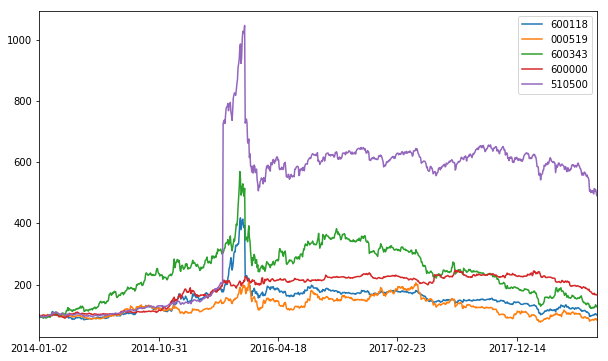

In [3]:
(df / df.iloc[0] * 100).plot(figsize=(10, 6))

In [4]:
# Calculate the yearly mean and variance of stocks
log_returns = np.log(df / df.shift(1))[1:]
means = log_returns.mean() * 252
covariance_matrix = log_returns.cov() * 252
print(means, covariance_matrix)

600118    0.006072
000519   -0.038631
600343    0.068651
600000    0.140100
510500    0.428569
dtype: float64           600118    000519    600343    600000    510500
600118  0.237544  0.107789  0.177607  0.017604  0.102006
000519  0.107789  0.209140  0.123730  0.012973  0.062838
600343  0.177607  0.123730  0.238805  0.013850  0.095337
600000  0.017604  0.012973  0.013850  0.064721  0.022130
510500  0.102006  0.062838  0.095337  0.022130  0.510833


## Expected Return and Variance of Portfolio

In [5]:
number = len(symbols)
weights = np.random.random(number)
weights = weights / np.sum(weights)

A general formula for expected returns
<img src='Expect Return.png'>
Portfolio covariance matrix
<img src='Covariance Matrix.png'>
Variance of Portfolio
<img src='Variance of Portfolio.png'>

In [7]:
Variance = np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
Standard_variance = np.sqrt(Variance)
print(Standard_variance)

0.2516145817909799


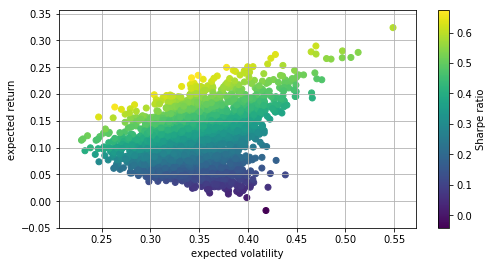

In [8]:
# Initialize more weights and to plot the expected return and the volatility
preturns = []
pvolatilities = []
for p in range(2500):
    weights = np.random.random(number)
    weights /= np.sum(weights)
    preturns.append(np.sum(log_returns.mean() * weights) * 252)
    pvolatilities.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))))

prets = np.array(preturns)
pvols = np.array(pvolatilities)

plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Portfolio optimization

In [9]:
# Define a function to calculate the expected return, volatility of portfolio
def statistics(weights):
    """
    Instruction: Return portfolio statistics
    
    Parameter: weights: weights for different securities in portfolio
    
    Return:
        pret: float, expected portfolio return
        pvol: float, expected portfolio volatility
        pret/pvol:float, Sharpe ratio for rf=0
    """
    weights = np.array(weights)
    pret = np.sum(log_returns.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [10]:
# define an objective: Maxmium the sharpe ratio
def max_sharpe(weights):
    # due to the optimization is to get the minmium of function
    # the return result is the objective
    return -statistics(weights)[2]

In [11]:
# the subjections
# the format is the tuple, each element represents a subjection
# each subjection is a dict, key_1 is the type of subjection: equal subjection: type:'eq' or 'ineq', which are compared with 0
#                             key_2 is the function of subjection. using lambda function
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# the constraints for parameters themselves, previous cons are the constraints of functions
bnds = tuple((0, 1) for x in range(number))
# the initial weights, to start the iteration
begins = number * [1 / number]
opts = sco.minimize(max_sharpe, begins, method='SLSQP', bounds=bnds, constraints=cons)

In [12]:
# Attributes of opts
# fun: -0.7689821435140733
# jac: array([3.62539694e-01, 3.84121098e-01, 1.03567891e-01,
#             -1.06185675e-04, 2.67580152e-04])
# message: 'Optimization terminated successfully.'
# nfev: 59
# nit: 8
# njev: 8
# status: 0
# success: True
# x: array([2.69140628e-17, 5.93820112e-17, 0.00000000e+00,
#           7.15876612e-01, 2.84123388e-01])

In [13]:
weights = opts['x'].round(3)
print(weights)
# the expected return, volatility and the sharpe ratio
statistics(opts['x'].round(3))

[0.    0.    0.    0.716 0.284]


array([0.2220253 , 0.28875841, 0.76889637])

In [14]:
# define an objective: Minmium the variance of portfolio
def min_variance(weights):
    # due to the optimization is to get the minmium of function
    # the return result is the objective
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# the constraints for parameters themselves, previous cons are the constraints of functions
# the weights should be within 0 and 1
bnds = tuple((0, 1) for x in range(number))
# the initial weights, to start the iteration
begins = number * [1 / number]
opts_variance = sco.minimize(min_variance, begins, method='SLSQP', bounds=bnds, constraints=cons)

In [15]:
print(opts_variance['x'].round(3))
statistics(opts_variance['x'].round(3))

[0.046 0.133 0.057 0.732 0.033]


array([0.11575077, 0.2269278 , 0.51007754])

## Efficient Frontier
Compared with previous work, we have to loop through multiple starting conditions here.The optimization uses two conditions: one is the target return level, and the other is the summation of portfolio weights should be 1 as before.The boundary value of each parameter remains unchanged

In [16]:
# adding a constraints for each efficient frontier point
total_returns = np.linspace(0.0, 0.25, 30)
# defina a list to store the sigma for each total_return
total_volatilities = []
bnds = tuple((0,1) for i in range(number))
for each in total_returns:
    cons = ({'type':'eq', 'fun': lambda x: statistics(x)[0] - each},
            {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    opts_ = sco.minimize(min_variance, begins, bounds=bnds, constraints=cons)
    total_volatilities.append(statistics(opts_['x'].round(3))[1])
total_volatilities = np.array(total_volatilities)

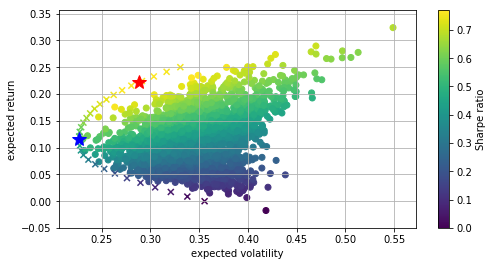

In [17]:
plt.figure(figsize=(8,4))
# random portfolio composition
plt.scatter(pvols, prets, c=prets/pvols,marker='o')
# efficient frontier
plt.scatter(total_volatilities, total_returns, c=total_returns/total_volatilities, marker='x')
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1],statistics(opts['x'])[0],'r*',markersize=15.0)
# minimum variance portfolio
plt.plot(statistics(opts_variance['x'])[1],statistics(opts_variance['x'])[0],'b*',markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Capital Market Line

In [18]:
import scipy.interpolate as sci

In [19]:
# risk free rate
rate = 0.01

In [20]:
index = np.argmin(total_volatilities)
evols = total_volatilities[index:]
erets = total_returns[index:]
# build a track, and find a continuously differentiable function
tck = sci.splrep(evols, erets)

In [21]:
def f(x):
    """
    Efficient frontier function (splines approximation)
    """
    return sci.splev(x, tck, der=0)

def df(x):
    """
    First derivative of efficient frontier function.
    """
    return sci.splev(x, tck, der=1)

In [22]:
# p=(a,b,x)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1]-df(p[2])
    return eq1,eq2,eq3
# solve the equation, and given the beginning value
opt=sco.fsolve(equations,[0.01,0.5,0.15])
print(opt)

[0.01       0.73483648 0.29290447]


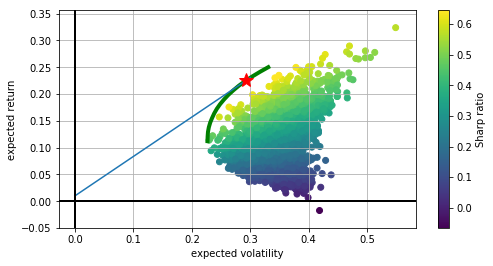

In [23]:
plt.figure(figsize=(8, 4))
# random portfolio composition
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker="o")
# efficient frontier
plt.plot(evols, erets, 'g', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
# capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='-', lw=2.0)
plt.axvline(0, color='k', ls='-', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharp ratio')

In [24]:
# calculate the weights when the market point
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(min_variance, begins,
                   method='SLSQP', bounds=bnds, constraints=cons)
print(res['x'].round(3))

[0.    0.    0.    0.705 0.295]
